Số dòng sau làm sạch: 397884
  InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  UnitPrice CustomerID         Country  Revenue  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom    15.30  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom    20.34  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom    22.00  


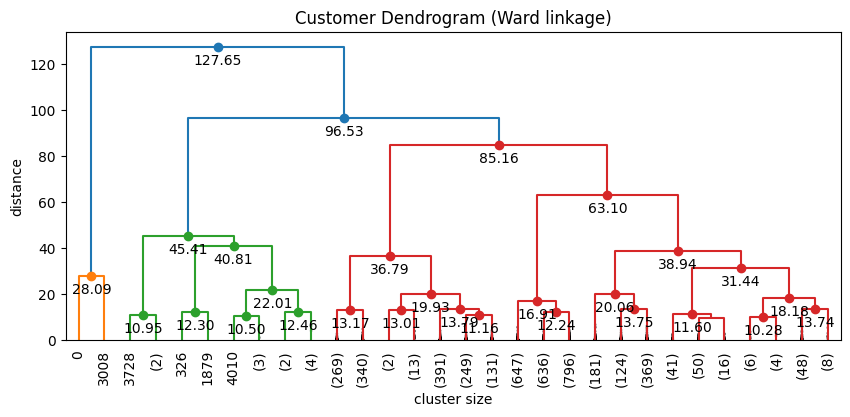


[So sánh Silhouette theo linkage (cắt k cụm giống nhau)]:
  Linkage=centroid | Silhouette=0.945
  Linkage=single   | Silhouette=0.967
  Linkage=complete | Silhouette=0.937
  Linkage=average  | Silhouette=0.945
  Linkage=weighted | Silhouette=0.967
  Linkage=ward     | Silhouette=0.908

Silhouette (SciPy fcluster, k=3):      0.908
Silhouette (sklearn Agglomerative, k=3): 0.945


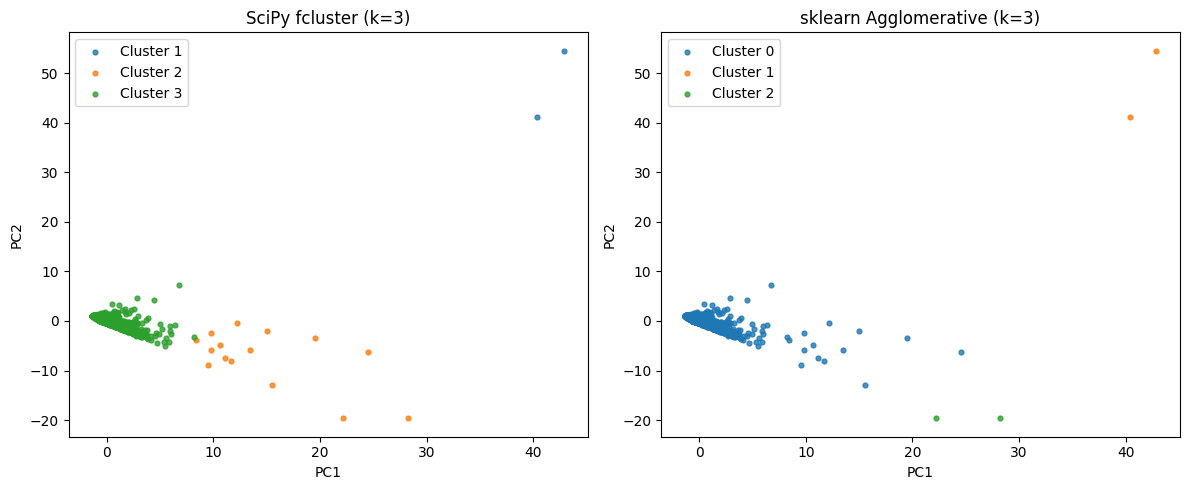


Silhouette (K-Means, k=3):               0.905

Tóm tắt theo cụm (Agglomerative):
        recency_days                              frequency                 \
                mean         std min  max count        mean       std  min   
cluster                                                                      
0          92.545916   99.968433   1  374  4334    4.180665  6.379410    1   
1         163.500000  229.809704   1  326     2    1.500000  0.707107    1   
2           1.000000    0.000000   1    1     2  205.000000  5.656854  201   

                    ... avg_items_per_invoice                              \
         max count  ...                  mean           std           min   
cluster             ...                                                     
0        124  4334  ...            227.123387    297.215988      1.000000   
1          2     2  ...          57356.750000  23841.165788  40498.500000   
2        209     2  ...            261.259873    195.258324    

In [1]:
# ===============================================
# 3.2. Phân cụm đa cấp (Hierarchical) - Supermarket Transactions
# Bám sát code & instruction mục 3.2 trong đề cương
# ===============================================
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans  # (tuỳ chọn) để so sánh
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings, sys
warnings.filterwarnings('ignore')

# -----------------------------
# 1) Import & làm sạch dữ liệu
# -----------------------------
CSV_PATH = "/kaggle/input/online-retail-customer-clustering/OnlineRetail.csv"  # <-- ĐỔI PATH CHO PHÙ HỢP
# Nếu file dùng dấu ; hay \t: thêm sep=';' hoặc sep='\t'
df = pd.read_csv(CSV_PATH, encoding='latin-1')

df.columns = [c.strip() for c in df.columns]
required = {'InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country'}
missing = required - set(df.columns)
if missing:
    print("Thiếu cột bắt buộc:", missing)
    sys.exit(1)

# Ép kiểu thời gian (UK format thường là ngày/tháng)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce', dayfirst=True)

# Loại bỏ CustomerID thiếu (không gom được theo khách)
df = df.dropna(subset=['CustomerID']).copy()
df['CustomerID'] = df['CustomerID'].astype(str)

# Bỏ hoá đơn huỷ (InvoiceNo bắt đầu 'C')
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.startswith('C', na=False)].copy()

# Lọc dòng hợp lệ
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

# Tạo Revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']

print("Số dòng sau làm sạch:", len(df))
print(df.head(3))

# ------------------------------------------------
# 2) Xây đặc trưng ở mức khách hàng (RFM + basket)
# ------------------------------------------------
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

grp = df.groupby('CustomerID', as_index=False).agg(
    last_purchase=('InvoiceDate', 'max'),
    frequency=('InvoiceNo', pd.Series.nunique),      # số hoá đơn
    monetary=('Revenue', 'sum'),                     # tổng chi
    total_qty=('Quantity', 'sum'),                   # tổng số lượng
    unique_items=('StockCode', pd.Series.nunique),   # số mã hàng khác nhau
)

grp['recency_days'] = (snapshot_date - grp['last_purchase']).dt.days
grp['avg_basket_value'] = grp['monetary'] / grp['frequency'].replace(0, np.nan)
grp['avg_items_per_invoice'] = grp['total_qty'] / grp['frequency'].replace(0, np.nan)

# Chọn feature để phân cụm (có thể tinh chỉnh tuỳ mục tiêu)
FEATS = [
    'recency_days', 'frequency', 'monetary',
    'avg_basket_value', 'avg_items_per_invoice', 'unique_items'
]

X = grp[FEATS].fillna(0).copy()

# ------------- Chuẩn hoá -------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------
# 3) SciPy: linkage (centroid/single/complete/average/weighted/ward),
#    dendrogram & cắt cụm bằng fcluster
# ---------------------------------------------------

# (A) Tạo linkage matrix với Ward (thường tốt cho dữ liệu numeric + euclidean)
Z = linkage(X_scaled, method='ward', metric='euclidean')

# (B) Vẽ dendrogram (giống phong cách 3.2.2.3)
def annotated_dendrogram(*args, **kwargs):
    scipy_dendro = dendrogram(*args, truncate_mode='lastp',
                              show_contracted=True, leaf_rotation=90.)
    plt.title('Customer Dendrogram (Ward linkage)')
    plt.xlabel('cluster size'); plt.ylabel('distance')
    for i, d, c in zip(scipy_dendro['icoord'], scipy_dendro['dcoord'], scipy_dendro['color_list']):
        x = 0.5 * sum(i[1:3]); y = d[1]
        if y > 10:  # ngưỡng gợi ý chú thích
            plt.plot(x, y, 'o', c=c)
            plt.annotate(f"{y:.2f}", (x, y), xytext=(0, -5),
                         textcoords='offset points', va='top', ha='center')
    return scipy_dendro

plt.figure(figsize=(10, 4))
_ = annotated_dendrogram(Z)
# Bạn có thể chọn ngưỡng cắt bằng một đường ngang (tuỳ dữ liệu):
# plt.axhline(y=20, c='r', ls='--')
plt.show()

# (C) Cắt theo số cụm k (ví dụ k=3) bằng criterion='maxclust'
k = 3
labels_scipy = fcluster(Z, t=k, criterion='maxclust')

# ---------------------------------------------------
# 4) Thử nhiều linkage (giống 3.2.2.5 trong tài liệu)
# ---------------------------------------------------
methods = ['centroid', 'single', 'complete', 'average', 'weighted', 'ward']
print("\n[So sánh Silhouette theo linkage (cắt k cụm giống nhau)]:")
for method in methods:
    Zm = linkage(X_scaled, method=method, metric='euclidean')
    cl = fcluster(Zm, t=k, criterion='maxclust')
    sil = silhouette_score(X_scaled, cl)
    print(f"  Linkage={method:<8} | Silhouette={sil:.3f}")

# ---------------------------------------------------
# 5) AgglomerativeClustering (scikit-learn) — giống mục 3.2.2.6
# ---------------------------------------------------
# Lưu ý: sklearn hỗ trợ 'single'/'complete'/'average'/'ward' (không có 'centroid'/'weighted')
ac = AgglomerativeClustering(n_clusters=k, linkage='average', metric='euclidean')
labels_sklearn = ac.fit_predict(X_scaled)

sil_scipy = silhouette_score(X_scaled, labels_scipy)
sil_sklearn = silhouette_score(X_scaled, labels_sklearn)
print(f"\nSilhouette (SciPy fcluster, k={k}):      {sil_scipy:.3f}")
print(f"Silhouette (sklearn Agglomerative, k={k}): {sil_sklearn:.3f}")

# ---------------------------------------------------
# 6) Trực quan 2D bằng PCA (minh hoạ cụm)
# ---------------------------------------------------
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
pal = sns.color_palette('tab10', n_colors=k)

# SciPy labels (1..k)
for c in range(1, k+1):
    idx = (labels_scipy == c)
    ax[0].scatter(X2[idx,0], X2[idx,1], s=12, alpha=0.8, color=pal[c-1], label=f'Cluster {c}')
ax[0].set_title(f'SciPy fcluster (k={k})'); ax[0].set_xlabel('PC1'); ax[0].set_ylabel('PC2'); ax[0].legend()

# sklearn labels (0..k-1)
for c in range(k):
    idx = (labels_sklearn == c)
    ax[1].scatter(X2[idx,0], X2[idx,1], s=12, alpha=0.8, color=pal[c], label=f'Cluster {c}')
ax[1].set_title(f'sklearn Agglomerative (k={k})'); ax[1].set_xlabel('PC1'); ax[1].set_ylabel('PC2'); ax[1].legend()

plt.tight_layout(); plt.show()

# ---------------------------------------------------
# 7) (Tuỳ chọn) So sánh với K-Means cùng k
# ---------------------------------------------------
km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
km_labels = km.fit_predict(X_scaled)
sil_km = silhouette_score(X_scaled, km_labels)
print(f"\nSilhouette (K-Means, k={k}):               {sil_km:.3f}")

# ---------------------------------------------------
# 8) Thống kê cụm (profile) để giải thích nhóm khách hàng
# ---------------------------------------------------
profile_cols = ['recency_days','frequency','monetary','avg_basket_value','avg_items_per_invoice','unique_items']
grp_ac = pd.concat([grp[['CustomerID']], pd.Series(labels_sklearn, name='cluster')], axis=1).merge(grp, on='CustomerID')
desc = grp_ac.groupby('cluster')[profile_cols].agg(['mean','std','min','max','count'])
print("\nTóm tắt theo cụm (Agglomerative):")
print(desc)
